# Testing the samplers

---

**Update:** See `paretochain.py` for an implementation that uses the notation from the paper. It also has a rejection sampler to sample from a Pareto chain upper bounded by a given $x_\max$.

## Sample from $p(\boldsymbol x|\boldsymbol F)$

In [1]:
%pylab inline
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sample_x(J, x0, Ex, size=1, u=None):
    # Concatenate hyperparameters
    F = [x0, *Ex]
    
    # Calculate scale parameters for the u ~ Exp(beta) such
    # that the marginal moments agree with Ex
    beta = [(F[j+1] - F[j])/F[j+1] for j in range(J)]
    
    # Draw the u
    u = scipy.stats.expon.rvs(scale=beta, size=(size,J))
    
    # Transform to x
    x = vstack([x0*exp(sum(u[:,0:j+1], axis=1)) for j in range(J)])
    
    return x if size > 1 else x[:,0] # (J, size)

num = 1000000
J = 3

x0 = 200
Ex = 500*(1 + arange(J))
print(Ex)

samples = sample_x(J, x0, Ex, size=num)
mean(samples, axis=1)

[ 500 1000 1500]


array([ 498.42666007,  995.00561791, 1501.68173688])

The result of imposing an upper bound on the `x` is a relatively large shift in the means away from the given values (constraints), despite the high acceptance ratio. The heavy tails of the pdfs for the frequency ratios manifest themselves.

In [3]:
fs = 11000
keep = all(samples < fs/2, axis=0)
print(f"Acceptance rate at fs = {fs}:", sum(keep)/num)
accept = samples[:,keep]
mean(accept, axis=1)

Acceptance rate at fs = 11000: 0.966036


array([ 409.23065918,  710.2499559 , 1011.15083031])

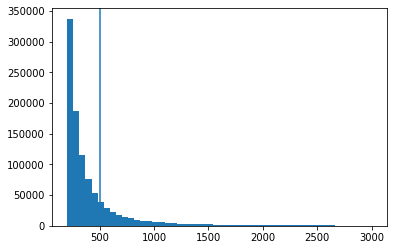

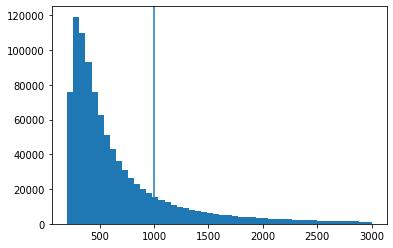

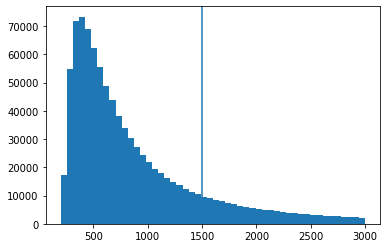

In [4]:
U = 3000
B = 50
for x in samples:
    hist(x[x<U], bins=B)
    axvline(mean(x))
    show()

### PPF version for use in nested sampling

In [5]:
from sample_ppf import sample_x_ppf

J = 4
x0 = 450
Ex = (800, 2000, 2500, 4000)

F = [x0, *Ex]

samples = vstack([sample_x_ppf(rand(J), J, F) for _ in range(10000)])
mean(samples,axis=0)

array([ 810.5196972 , 1974.20010345, 2462.88118438, 4042.9427526 ])

## Testing PPF Jeffreys sampler

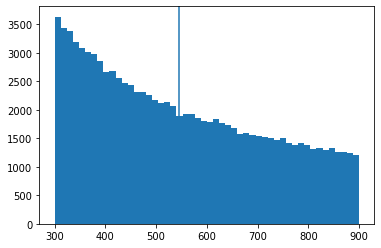

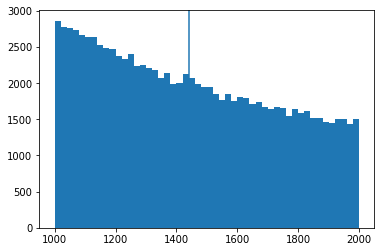

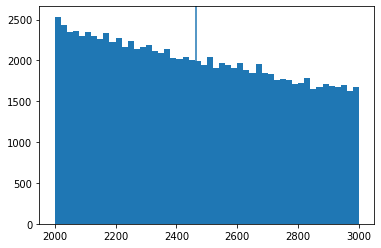

In [6]:
from sample_ppf import sample_jeffreys_ppf

bounds = [(300., 1000., 2000., 2500.), (900., 2000., 3000., 4000.)]
J = 3

samples = vstack([sample_jeffreys_ppf(rand(J), bounds) for _ in range(100000)])
for x in samples.T:
    hist(x, bins=B)
    axvline(mean(x))
    show()

## Testing `ptform_XXX()`

In [7]:
import model
import hyper_cmp

hyper = hyper_cmp.get_hyperparameters()
print(hyper)

({'b': [(10.0, 20.0, 20.0, 20, 20.0), (300.0, 300.0, 400.0, 400.0, 500.0)], 'f': [(200.0, 600.0, 1400.0, 2900, 3500.0), (1100.0, 3500.0, 4000.0, 4500.0, 5500.0)]}, [200.0, 500.0, 1000.0, 1500.0, 2000.0, 2500.0], 1.0)


### `ptform_old`

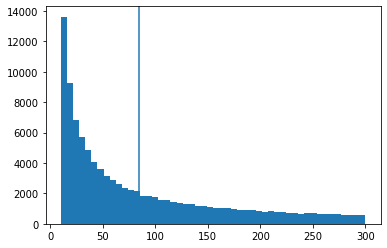

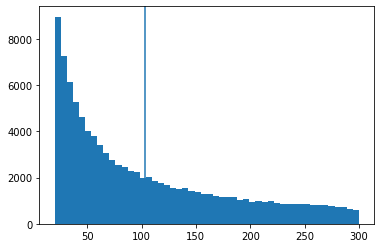

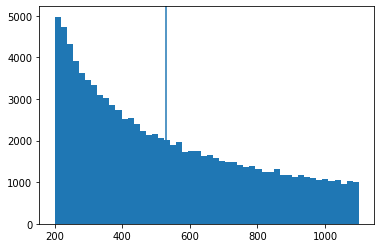

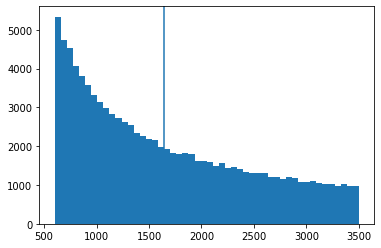

In [8]:
Q = 2
order = (None, Q)

samples = vstack([model.ptform_old(rand(Q*2), order, hyper) for _ in range(100000)])
for x in samples.T:
    hist(x, bins=B)
    axvline(mean(x))
    show()

### `ptform_new`

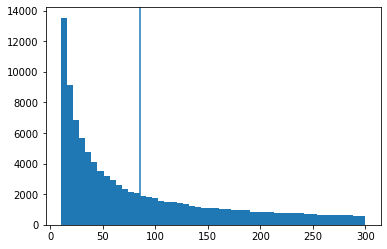

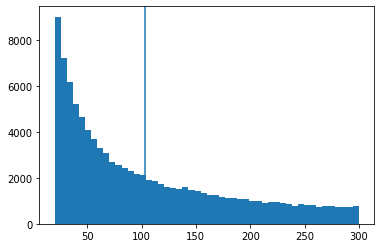

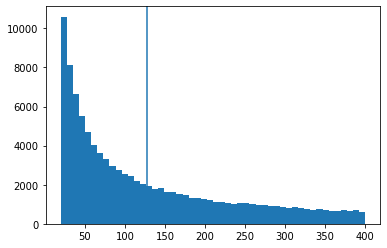

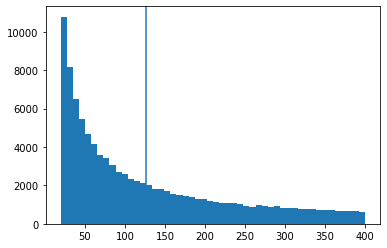

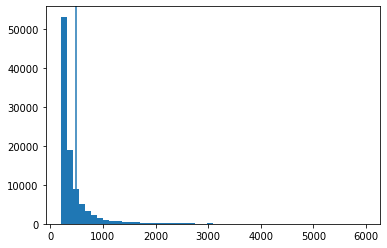

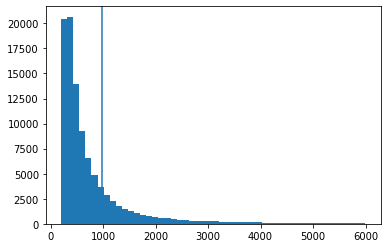

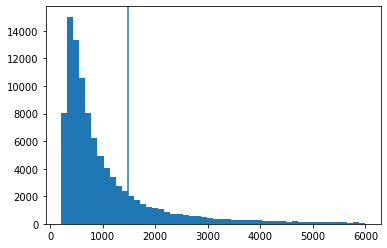

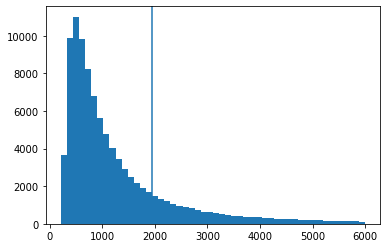

In [9]:
Q = 4
order = (None, Q)

samples = vstack([model.ptform_new(rand(Q*2), order, hyper) for _ in range(100000)])

U = 6000
B = 50
for x in samples.T:
    hist(x[x<U], bins=B)
    axvline(mean(x))
    show()